In [ ]:
#default_exp data.block

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.transform import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc

In [ ]:
#For examples, so not exported
from local.vision.core import *
from local.vision.augment import *

# Data block

> High level API to quickly get your data in a `DataBunch`

## General API

In [ ]:
#export
from inspect import isfunction,ismethod

In [ ]:
#export
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), lambda o:
        o if isinstance(o, type) else o.__qualname__ if (isfunction(o) or ismethod(o)) else o.__class__)
    res = [sorted(v, key=lambda o: isinstance(o,type))[0] for k,v in g.items()]
    return [t() if isinstance(t, type) else t for t in res]

In [ ]:
#hide
tfms = _merge_tfms(Categorize, MultiCategorize, Categorize(['dog', 'cat']))
#Categorize is there twice, the generic version is removed and the instantiated one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['dog', 'cat'])

tfms = _merge_tfms(Categorize(['dog', 'cat']), [Categorize, MultiCategorize])
#Same in the other direction.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['dog', 'cat'])

tfms = _merge_tfms([Categorize, MultiCategorize, Categorize(['a', 'b']), Categorize(['dog', 'cat'])])
#If there are several instantiated versions, the first one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['a', 'b'])

tfms = _merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = _merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
#export
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `DataSource` and `DataBunch`"
    get_items=splitter=labeller = noops
    _methods = 'get_items splitter labeller'.split()
    def __init__(self, ts=None, **kwargs):
        types = L(getattr(self,'types',(float,float)) if ts is None else ts)
        self.default_type_tfms = types.mapped(
            lambda t: L(getattr(t,'create',None)) + L(getattr(t,'default_type_tfms',None)))
        self.default_ds_tfms = _merge_tfms(*types.attrgot('default_ds_tfms', L()), ToTensor)
        self.default_dl_tfms = _merge_tfms(*types.attrgot('default_dl_tfms', L()), Cuda)

    def datasource(self, source, type_tfms=None):
        self.source = source
        items = self.get_items(source)
        splits = self.splitter(items)
        labellers = [None,self.labeller] if isinstance(self.labeller, Callable) else self.labeller
        if type_tfms is None: type_tfms = [L() for t in self.default_type_tfms]
        type_tfms = L([self.default_type_tfms, type_tfms, labellers]).mapped_zip(
            lambda tt,tfm,l: L(l) + _merge_tfms(tt, tfm))
        return DataSource(items, tfms=type_tfms, filts=splits)
    
    def databunch(self, source, type_tfms=None, ds_tfms=None, dl_tfms=None, bs=16, **kwargs):
        dsrc = self.datasource(source, type_tfms=type_tfms)
        ds_tfms = _merge_tfms(self.default_ds_tfms, ds_tfms)
        dl_tfms = _merge_tfms(self.default_dl_tfms, dl_tfms)
        return dsrc.databunch(bs=bs, after_item=ds_tfms, after_batch=dl_tfms, **kwargs)
    
    _docs = dict(get_items="Pass at init or implement how to get your raw items from a `source`",
                 splitter="Pass at init or implement how to split your `items`",
                 labeller="Pass at init or implement how to label a raw `item`",
                 datasource="Create a `Datasource` from `source` with `tfms` and `tuple_tfms`",
                 databunch="Create a `DataBunch` from `source` with `tfms`")

In [ ]:
#export
def col_labeler(item, df, col, pref='', suff='', label_delim=None): 
    "Label `item` looking in `col` of `df` with potention `pref` or `suff` and `label_delim`"
    res = pref + str(df[col][item]) + suff
    if label_delim is not None: res = [t for t in res.split(label_delim) if len(t)>0]
    return res

In [ ]:
#export
def ColLabeler(col, pref='', suff='', label_delim=None):
    "Retun a labeller for `col` when the `source` is a dataframe"
    def _inner(self, item): return col_labeler(item, self.source, col=col, pref=pref, suff=suff, label_delim=label_delim)
    return _inner

### Building a `DataBlock`

To build a `DataBlock` you need to give the lbirary four things: the types of your input/labels then three function.

In [ ]:
show_doc(DataBlock.get_items)

<h4 id="<code>noops</code>" class="doc_header"><code>noops</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#Basics" class="source_link" style="float:right">[source]</a></h4>

> <code>noops</code>(**`x`**=*`None`*, **\*`args`**, **\*\*`kwargs`**)

Pass at init or implement how to label a raw `item`

In [ ]:
show_doc(DataBlock.splitter)

<h4 id="<code>noops</code>" class="doc_header"><code>noops</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#Basics" class="source_link" style="float:right">[source]</a></h4>

> <code>noops</code>(**`x`**=*`None`*, **\*`args`**, **\*\*`kwargs`**)

Pass at init or implement how to label a raw `item`

In [ ]:
show_doc(DataBlock.labeller)

<h4 id="<code>noops</code>" class="doc_header"><code>noops</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#Basics" class="source_link" style="float:right">[source]</a></h4>

> <code>noops</code>(**`x`**=*`None`*, **\*`args`**, **\*\*`kwargs`**)

Pass at init or implement how to label a raw `item`

### Using a `DataBlock`

Once those informations are all provided, you automatically get a `DataSource` or a `DataBunch`:

In [ ]:
show_doc(DataBlock.datasource)

<h4 id="<code>DataBlock.datasource</code>" class="doc_header"><code>DataBlock.datasource</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasource</code>(**`source`**, **`type_tfms`**=*`None`*)

Create a `Datasource` from `source` with `tfms` and `tuple_tfms`

In [ ]:
show_doc(DataBlock.databunch)

<h4 id="<code>DataBlock.databunch</code>" class="doc_header"><code>DataBlock.databunch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.databunch</code>(**`source`**, **`type_tfms`**=*`None`*, **`ds_tfms`**=*`None`*, **`dl_tfms`**=*`None`*, **`bs`**=*`16`*, **\*\*`kwargs`**)

Create a [`DataBunch`](/data.core.html#DataBunch) from `source` with `tfms`

## Examples

### Classification

In [ ]:
#export vision.core
PILBase.default_dl_tfms = ByteToFloatTensor

In [ ]:
class MNIST(DataBlock):
    types = PILImageBW,Category
    def get_items(self, source): return get_image_files(Path(source))
    def splitter (self, items ): return GrandparentSplitter()(items)
    def labeller (self, item  ): return parent_label(item)

In [ ]:
mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))
#TODO: access vocab
# mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY), type_tfms=[None, Categorize(['1', '2', '3', '4'])])
#test_eq(mnist.vocab, ['1', '2', '3', '4'])

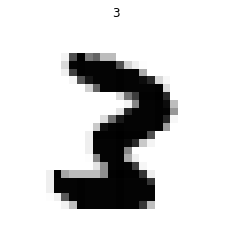

In [ ]:
mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))
mnist.train.show_at(0, cmap='Greys');

In [ ]:
mnist = DataBlock(ts=(PILImageBW, Category), 
                  get_items=(get_image_files), 
                  splitter=GrandparentSplitter(),
                  labeller=parent_label)

In [ ]:
dbunch = mnist.databunch(untar_data(URLs.MNIST_TINY))

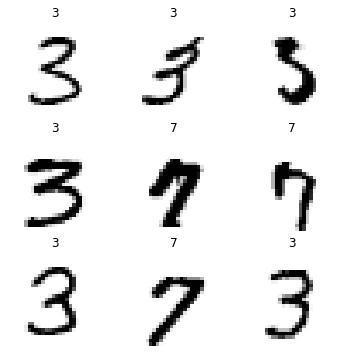

In [ ]:
dbunch.show_batch(max_samples=9, figsize=(6,6))

In [ ]:
pets = DataBlock(ts=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 labeller=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

In [ ]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", ds_tfms=Resize(128),
                        dl_tfms=aug_transforms())

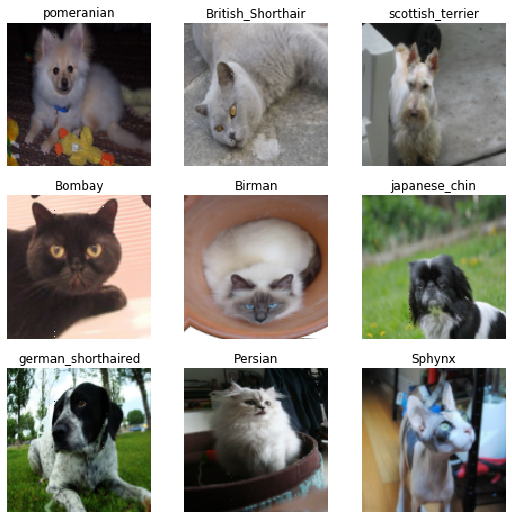

In [ ]:
dbunch.show_batch(max_samples=9)

### Multi-label classification

In [ ]:
#export
MultiCategory.default_type_tfms = OneHotEncode

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

In [ ]:
#TODO: make tfms grab order from func

@Transform
def name2fn(row): return planet_source/"train"/f'{row[1]}.jpg'
name2fn.order = -2

def _lbl(row): return row[2].split(' ')

planet = DataBlock(ts=(PILImage, MultiCategory),
                   get_items=compose(pd.DataFrame.itertuples,list),
                   splitter=RandomSplitter(),
                   labeller=_lbl)

In [ ]:
#TODO: fix flip_vert
dbunch = planet.databunch(df, type_tfms=[name2fn, None],
                          dl_tfms=aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

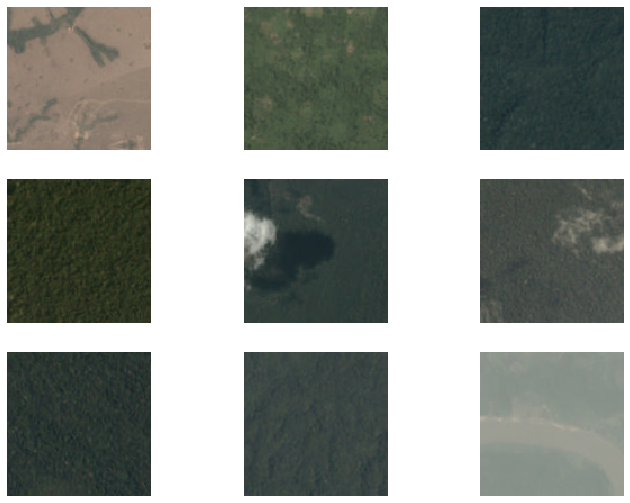

In [ ]:
dbunch.show_batch(max_samples=9, figsize=(12,9))

### Segmentation

In [ ]:
camvid = DataBlock(ts=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   labeller=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images", dl_tfms=aug_transforms())

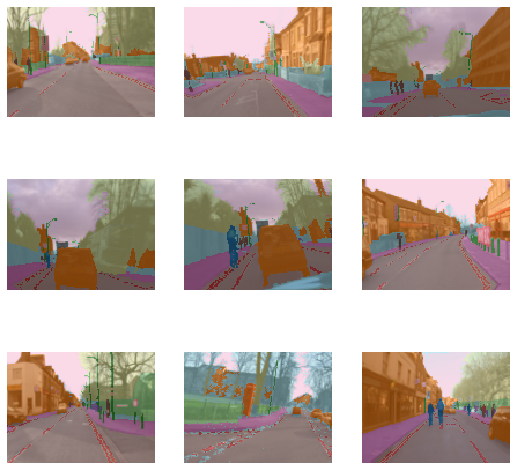

In [ ]:
dbunch.show_batch(max_samples=9, vmin=1, vmax=30)

### Points

In [ ]:
#export vision.core
TensorPoint.default_ds_tfms = PointScaler

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi_source/'centers.pkl', 'rb'))

biwi = DataBlock(ts=(PILImage, TensorPoint),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 labeller=lambda o:fn2ctr[o.name].flip(0))

In [ ]:
dbunch = biwi.databunch(biwi_source, dl_tfms=aug_transforms())

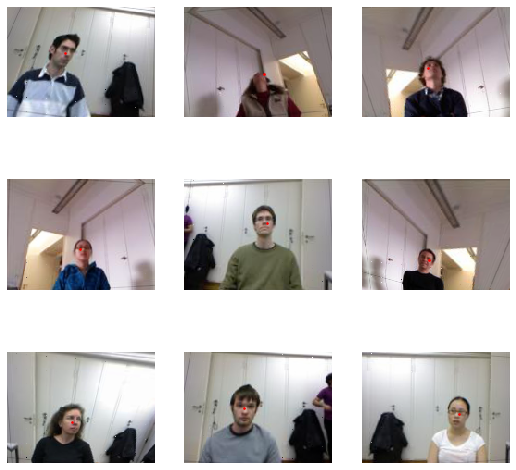

In [ ]:
dbunch.show_batch(max_samples=9)

### Bounding boxes

In [ ]:
#export vision.core
BBox.default_type_tfms,BBox.default_ds_tfms = BBoxCategorize,BBoxScaler

In [ ]:
#export vision.core
def bb_pad(samples, pad_idx=0):
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    max_len = max([len(s[1][1]) for s in samples])
    def _f(img,bbox,lbl):
        bbox = torch.cat([bbox,bbox.new_zeros(max_len-bbox.shape[0], 4)])
        lbl  = torch.cat([lbl, lbl .new_zeros(max_len-lbl .shape[0])+pad_idx])
        return img,TensorBBox((bbox,lbl))
    return [_f(x,*y) for x,y in samples]

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

coco = DataBlock(ts=(PILImage, BBox),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 labeller=lambda o: img2bbox[o.name])

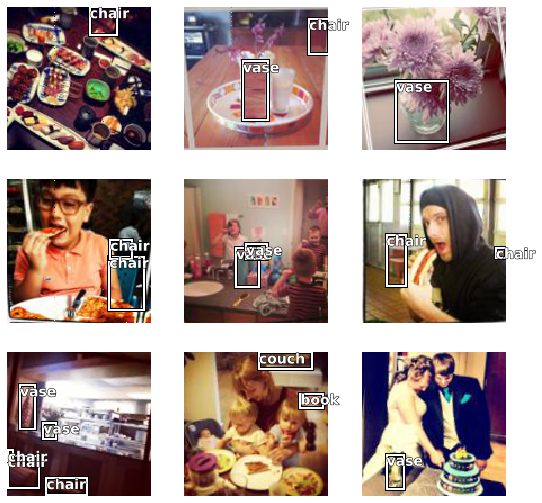

In [ ]:
dbunch = coco.databunch(coco_source, ds_tfms=Resize(128), dl_tfms=aug_transforms(), before_batch=bb_pad)
dbunch.show_batch(max_samples=9)

### Language model TODO

### Text classification TODO

### Tabular data

In [ ]:
from local.tabular.core import *

In [ ]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]

In [ ]:
df,proc = process_df(df, RandomSplitter(), procs=procs, cat_names=cat_names, cont_names=cont_names)

In [ ]:
adult = DataBlock(ts=(TabularLine, Category),
                  get_items=range_of,
                  splitter=RandomSplitter(),
                  labeller=[ReadTabLine(df, proc), ColLabeler('salary')])

In [ ]:
dbunch = adult.databunch(df)

In [ ]:
dbunch.show_batch()

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_dataloader.ipynb.
Converted 01a_script.ipynb.
Converted 02_transforms.ipynb.
Converted 03_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 10_data_block.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_text_models_